In [15]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
train_dir = r'chest_xray\train'
test_dir = r'chest_xray\test'
val_dir = r'chest_xray\val'

In [4]:
IMAGE_SIZE = [224, 244]


In [5]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
for layer in vgg.layers:
    layer.trainable = False

In [7]:
folders = glob('chest_xray/train/*')
print(folders)

['chest_xray/train\\NORMAL', 'chest_xray/train\\PNEUMONIA']


In [8]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 61, 128)       0     

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
va_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
training_set = train_datagen.flow_from_directory('chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [13]:
test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [14]:
val_set = test_datagen.flow_from_directory('chest_xray/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 16 images belonging to 2 classes.


In [16]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [205]:
r = model.fit(
  training_set,
  validation_data=val_set,
  epochs=500,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
  callbacks=[early_stopping]
)

Epoch 1/500
163/163 [==============================] - 366s 2s/step - loss: 0.2313 - accuracy: 0.9095 - val_loss: 0.3278 - val_accuracy: 0.8750
Epoch 2/500
163/163 [==============================] - 368s 2s/step - loss: 0.1094 - accuracy: 0.9555 - val_loss: 0.2743 - val_accuracy: 0.8750
Epoch 3/500
163/163 [==============================] - 356s 2s/step - loss: 0.0871 - accuracy: 0.9678 - val_loss: 0.2284 - val_accuracy: 0.9375
Epoch 4/500
163/163 [==============================] - 358s 2s/step - loss: 0.0851 - accuracy: 0.9691 - val_loss: 0.4248 - val_accuracy: 0.7500
Epoch 5/500
163/163 [==============================] - 356s 2s/step - loss: 0.0891 - accuracy: 0.9653 - val_loss: 0.3983 - val_accuracy: 0.8125
Epoch 6/500
163/163 [==============================] - 356s 2s/step - loss: 0.0765 - accuracy: 0.9712 - val_loss: 0.2329 - val_accuracy: 0.9375
Epoch 7/500
163/163 [==============================] - 356s 2s/step - loss: 0.0661 - accuracy: 0.9755 - val_loss: 0.4089 - val_accuracy:

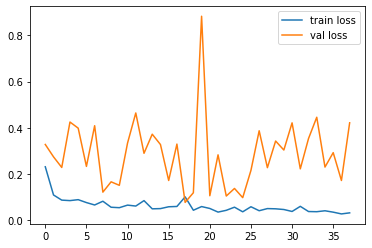

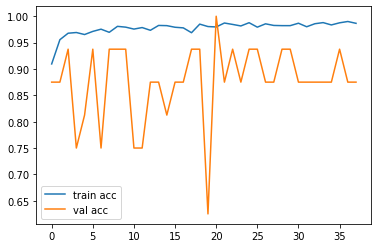

<Figure size 432x288 with 0 Axes>

In [207]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [209]:
model.save_weights(r'C:\Users\Biki\.vscode\Project Files\.vscode\Pnemonia Prediction\training_1\cp.ckpt')

In [210]:
from keras.models import load_model

model.save(r'C:\Users\Biki\.vscode\Project Files\.vscode\Pnemonia Prediction\Models\model_vgg16.h5')